In [1]:
# reading the TexNet waveform recorded at a station in west TX to see if there is any seismicity rate increase
# author - Kaushik Pradhan (kpradhan@miners.utep.edu)
# Last modified - 02/20/2024

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap

from obspy.clients.fdsn.client import Client
from obspy.core.utcdatetime import UTCDateTime


In [3]:
#trying to retrive data from a sample station - PB28
client = Client('texnet')
starttime = UTCDateTime('2021-01-01T00:00:00')
endtime = UTCDateTime('2021-01-01T01:00:00')
stream = client.get_waveforms('TX', 'PB28', '00', 'HHZ', starttime, endtime)
stream.plot()

FDSNNoServiceException: No FDSN services could be discovered at 'http://rtserve.beg.utexas.edu'. This could be due to a temporary service outage or an invalid FDSN service address.

In [ ]:
# this station was installed on March 2020, so looking for big earthquake in the region after that
# read the csv file from a link - magnitude Mw 6.5+ earthquakes after 2020-03-05T22:00:00 to today

usgs_url = 'https://earthquake.usgs.gov/fdsnws/event/1/query.csv?starttime=2020-03-05%2022:00:00&endtime=2024-02-20%2023:59:59&minmagnitude=6.5&orderby=time'
usgs_data = pd.read_csv(usgs_url)

# get the statistics of the data
print(usgs_data.describe())

         latitude   longitude       depth         mag         nst         gap  \
count  172.000000  172.000000  172.000000  172.000000   86.000000  170.000000   
mean    -2.468204   24.001341  107.717645    6.887209  179.046512   31.859941   
std     29.593539  127.877910  180.317613    0.366522   80.028805   19.071958   
min    -61.809800 -179.374100    2.700000    6.500000   18.000000    8.000000   
25%    -23.005725  -82.445400   10.750000    6.600000  128.750000   19.250000   
50%     -6.212700   72.085850   26.471500    6.800000  153.000000   27.000000   
75%     18.305850  140.496000   93.750000    7.000000  230.000000   37.000000   
max     56.295400  179.998100  660.000000    8.200000  410.000000  122.000000   

             dmin         rms  horizontalError  depthError    magError  \
count  169.000000  171.000000       168.000000  171.000000  168.000000   
mean     3.521515    0.779982         7.122857    2.008713    0.049821   
std      3.192943    0.200455         1.880871  

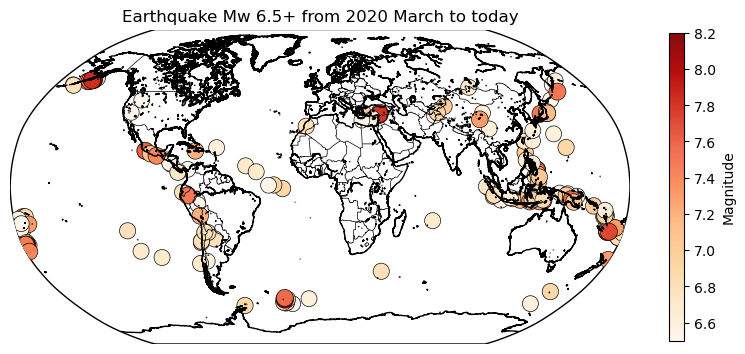

In [ ]:
plt.figure(figsize=(10, 8))
map = Basemap(projection='robin', resolution='i', lat_0=0, lon_0=0)

map.drawcoastlines()
map.drawcountries()

x, y = map(usgs_data['longitude'], usgs_data['latitude'])
sc = map.scatter(x, y, s=usgs_data['mag']*20.0, c=usgs_data['mag'], cmap='OrRd', alpha=0.95, edgecolors='k', linewidth=0.5)

plt.title('Earthquake Mw 6.5+ from 2020 March to today')

cbar = plt.colorbar(sc, shrink=0.5)
cbar.set_label('Magnitude')

plt.show()

In [ ]:
# read the an earthquake line from usgs_data
print(usgs_data.iloc[10])

time                    2023-12-02T14:37:04.454Z
latitude                                  8.5266
longitude                               126.4161
depth                                       40.0
mag                                          7.6
magType                                      mww
nst                                        128.0
gap                                         43.0
dmin                                       1.668
rms                                         0.98
net                                           us
id                                    us7000lff4
updated                 2024-02-06T21:53:58.040Z
place              19 km E of Gamut, Philippines
type                                  earthquake
horizontalError                             8.48
depthError                                 1.895
magError                                   0.028
magNst                                     124.0
status                                  reviewed
locationSource      

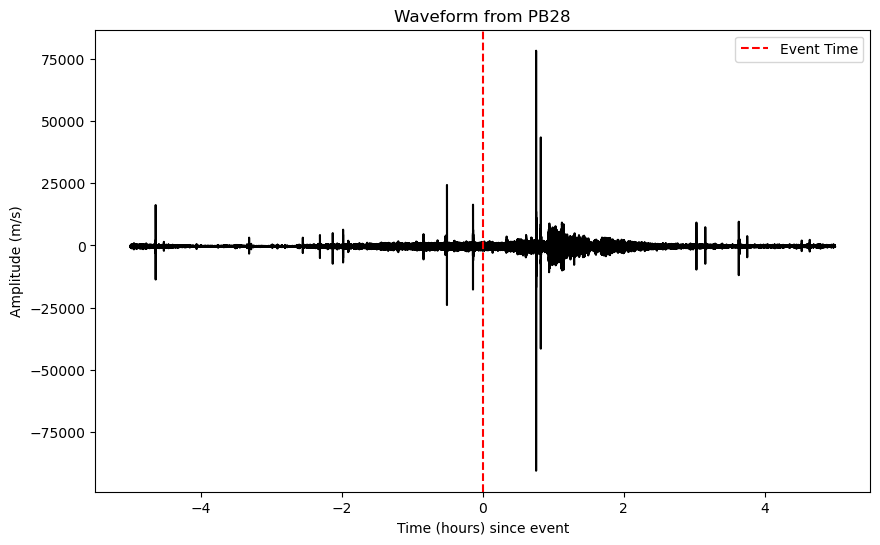

In [ ]:
eq_time = UTCDateTime(usgs_data.iloc[10]['time'])
starttime = eq_time - 5 * 3600 # 5 hours before the event
endtime = eq_time + 5 * 3600

stream = client.get_waveforms('TX', 'PB28', '00', 'HHZ', starttime, endtime)

data = stream[0].data

# Create a time array for the waveform
sampling_rate = stream[0].stats.sampling_rate
num_samples = len(data)
times_seconds = [(starttime + i / sampling_rate) - eq_time for i in range(num_samples)]  # Time array in seconds
times_hours = [t / 3600 for t in times_seconds]  # Convert seconds to hours

plt.figure(figsize=(10, 6))
plt.plot(times_hours, data, 'k')  
plt.title('Waveform from PB28')
plt.xlabel('Time (hours) since event')
plt.ylabel('Amplitude (m/s)')
plt.axvline(x=0, color='r', linestyle='--', label='Event Time')  
plt.legend()
plt.show()

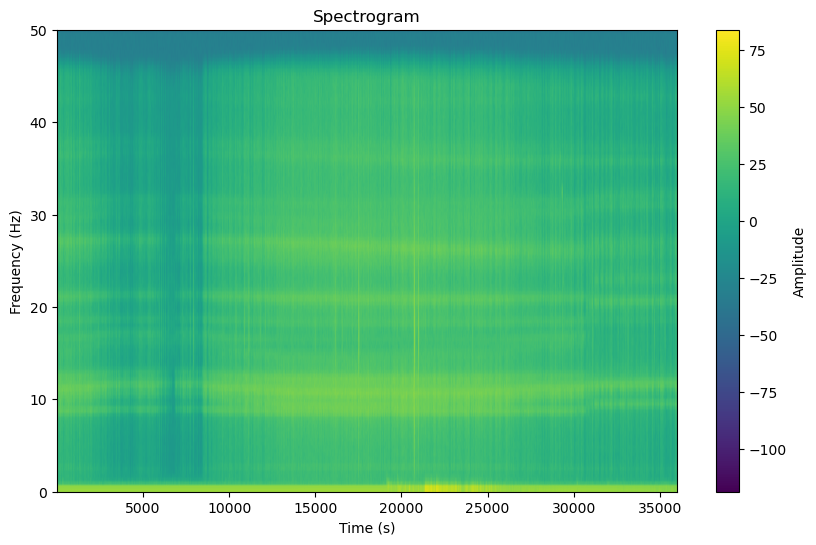

In [ ]:
#plot spectrogram
plt.figure(figsize=(10, 6))
plt.specgram(data, Fs=sampling_rate, NFFT=256, noverlap=128, cmap='viridis')
plt.title('Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Amplitude')
plt.show()

In [ ]:
print(sampling_rate)

100.0


In [ ]:
# implement simple STA/LTA algorithm to detect the seismicity rate increase

def sta_lta(trace, sta_window, lta_window):
    """
    Compute STA/LTA (Short-Term Average to Long-Term Average) ratio.

    Parameters:
    - trace: numpy array, seismic time series data
    - sta_window: int, window length (in samples) for short-term average (STA)
    - lta_window: int, window length (in samples) for long-term average (LTA)

    Returns:
    - ratio: numpy array, STA/LTA ratio
    """

    # Compute short-term average (STA)
    sta = np.convolve(trace**2, np.ones(sta_window)/sta_window, mode='same')

    # Compute long-term average (LTA)
    lta = np.convolve(trace**2, np.ones(lta_window)/lta_window, mode='same')

    # Compute STA/LTA ratio
    ratio = sta / lta

    return ratio

# Example usage:
# Assuming you have seismic time series data in 'trace' variable
# Set window lengths for STA and LTA
sta_window = 100  # Short-Term Average window length in samples
lta_window = 1000  # Long-Term Average window length in samples

# Compute STA/LTA ratio
sta_lta_ratio = sta_lta(data, sta_window, lta_window)


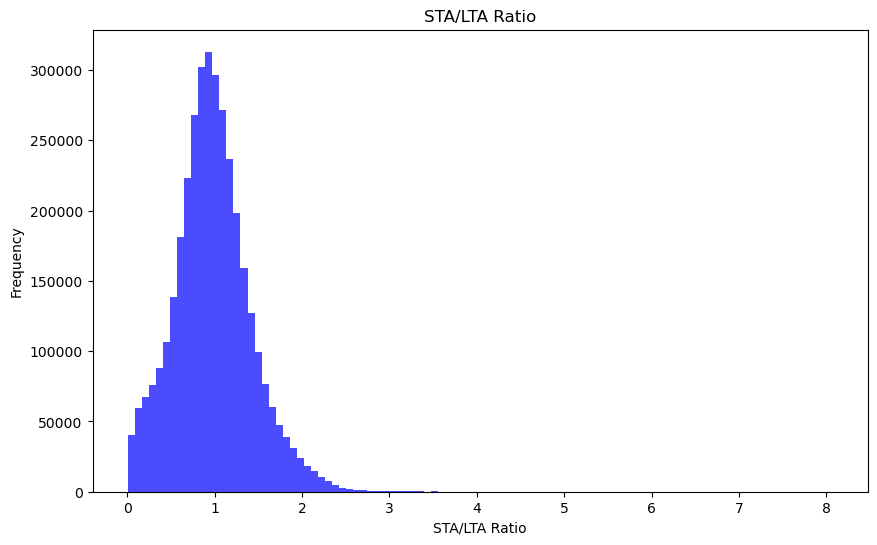

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(sta_lta_ratio, bins=100, color='b', alpha=0.7)
plt.title('STA/LTA Ratio')
plt.xlabel('STA/LTA Ratio')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Find indices where STA/LTA ratio crosses threshold
crossings = np.where(np.diff(sta_lta_ratio > 3))[0]

# Find the index of the earthquake
if sta_lta_ratio[0] > 1:
    # If the first value crosses the threshold
    earthquake_index = crossings[0]
else:
    # If the first value is below the threshold, the earthquake occurred before the data
    earthquake_index = 0

# Seismicity rate before the earthquake
seismicity_rate_before = len(sta_lta_ratio[:earthquake_index][sta_lta_ratio[:earthquake_index] > 1])

# Seismicity rate after the earthquake
seismicity_rate_after = len(sta_lta_ratio[earthquake_index:][sta_lta_ratio[earthquake_index:] > 1])

print("Seismicity rate before earthquake:", seismicity_rate_before)
print("Seismicity rate after earthquake:", seismicity_rate_after)

Seismicity rate before earthquake: 61115
Seismicity rate after earthquake: 1571367


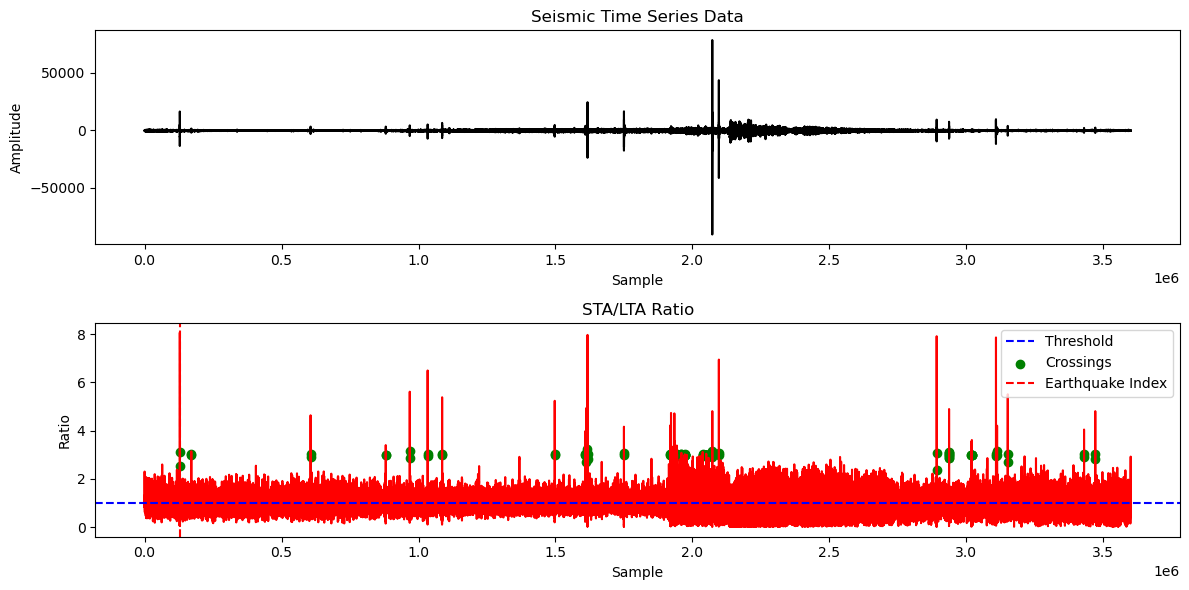

In [ ]:
import matplotlib.pyplot as plt

# Plot seismic time series data
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(data, 'k')
plt.title('Seismic Time Series Data')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

# Plot STA/LTA ratio
plt.subplot(2, 1, 2)
plt.plot(sta_lta_ratio, 'r')
plt.axhline(y=1, color='b', linestyle='--', label='Threshold')

# Mark threshold crossing points
plt.scatter(crossings, sta_lta_ratio[crossings], color='g', marker='o', label='Crossings')

# Highlight earthquake index
plt.axvline(x=earthquake_index, color='r', linestyle='--', label='Earthquake Index')

plt.title('STA/LTA Ratio')
plt.xlabel('Sample')
plt.ylabel('Ratio')
plt.legend()
plt.tight_layout()
plt.show()
